## Convolutional neuronal network

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
WORKING_PATH = '/content/drive/MyDrive/KeepCoding/DeepLearning/exercise'

In [ ]:
%cd {WORKING_PATH}

/content/drive/MyDrive/KeepCoding/DeepLearning/exercise


In [ ]:
!pip install optuna
#!pip install -r requirements.tx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 18.9 MB/s eta 0:00:00


In [ ]:
import sys
import pandas as pd
import numpy as np
import matplotlib as plt
import os
import torch
from torch.utils.data import Dataset, TensorDataset
from torchvision import transforms
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from sklearn.preprocessing import MultiLabelBinarizer, MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
import optuna
import pickle
import cv2

In [ ]:
# to load custom libraries
sys.path.append(WORKING_PATH)
from utilsMAP import *

# load dataset
poi_data = pd.read_csv(os.path.join(WORKING_PATH, "poi_dataset.csv"))

set_random_seed()

In [ ]:
# split into train, val and test datasets
df_train, df_test = train_test_split(poi_data, test_size = 0.2, random_state = 16)
df_train, df_val = train_test_split(df_train, test_size = 0.2, random_state = 16)
print(f'Number of samples.')
print(f'Train dataset: {df_train.shape[0]}')
print(f'Validation dataset: {df_val.shape[0]}')
print(f'Test dataset: {df_test.shape[0]}')

Number of samples.
Train dataset: 1004
Validation dataset: 251
Test dataset: 314


In [ ]:
# calculate engagement score
df_engagement = df_train[['Visits','Bookmarks','Likes','Dislikes']].copy()
df_engagement['Likes_Dislikes'] = df_engagement['Likes'] - df_engagement['Dislikes']
df_engagement = df_engagement.drop(['Likes','Dislikes'], axis=1)
scaler_engagement = MinMaxScaler().fit(df_engagement)

# Calculate scores
def categorize_score(x):
  if x < 0.31:
    return 0
  elif x >= 0.31 and x < 0.52:
    return 1
  elif x > 0.52:
    return 2


In [ ]:
def processdata(df):
  """
  Data processing steps before being used in the model.
  Processing include:
  - Calculate engagement feature (low, medium, high)
  - Select features
  """
  # Engagement features
  df['Likes_Dislikes'] = df['Likes'] - df['Dislikes']
  df_engagement = df[['Visits','Bookmarks','Likes_Dislikes']]
  df['Score']= scaler_engagement.transform(df_engagement).sum(axis = 1)/3
  df['engagement'] = df['Score'].apply(categorize_score)
  # Remove features
  df_clean = df.loc[:,['engagement','main_image_path']]
  return df_clean

In [ ]:
  df_train_proc = processdata(df_train)
  df_val_proc = processdata(df_val)
  df_test_proc = processdata(df_test)

In [ ]:
df_val_proc.head().T
df_val_proc.head().T
#df_train_proc.shape
#df_val_proc['engagement'].value_counts()


,827,1302,1439,205,266
engagement,0,0,1,0,1
main_image_path,data_main/e9db85f0-a7e5-47d9-b5bf-c9679f9f5490...,data_main/23869080-e075-47f0-bb14-a07f6c704995...,data_main/e50c847d-8c94-4dc6-887e-88545c3082c6...,data_main/4cd73b93-660e-4b18-a47b-fb2840545c5f...,data_main/85bd9134-3625-4e75-ba77-fb8196c06626...


In [ ]:
# Dataset
class CNNDataset(Dataset):
  def __init__(self, engagement, image_path, transform=None):
    self.engagement = torch.tensor(engagement.values)
    self.image_path = image_path
    self.transform = transform

  def __len__(self):
        return len(self.engagement)

  def __getitem__(self, idx):
        image = cv2.imread(os.path.join(WORKING_PATH,self.image_path.iloc[idx]))
        if transform:
          image = transform(image)
        engagement = self.engagement
        return image, engagement[idx]

In [ ]:
# Create dataset
transform = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = CNNDataset(df_train_proc['engagement'], df_train_proc['main_image_path'])
val_dataset = CNNDataset(df_val_proc['engagement'], df_val_proc['main_image_path'])
test_dataset = CNNDataset(df_test_proc['engagement'], df_test_proc['main_image_path'])

In [ ]:
#batch_size=16
#train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
#for e in train_loader:
##  print(e[0])
#  print(e[0].shape)
#  print(e[1])
#  break

In [ ]:
# Hyperparameters
num_epochs = 10
batch_size = 32
learning_rate = 0.01
dropout_rate = 0.2

In [ ]:
# Define CNN
class CNN(nn.Module):
    def __init__(self, dropout_rate):
        super(CNN, self).__init__()

        # First convolutional layer
        self.convLayer1 = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding = 1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Dropout(dropout_rate)
        )

        # Fully connected layer (classificator)
        self.fcLayer1 = nn.Sequential(
            nn.Linear(64, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(64, 3)
        )

        # Set global pooling (max/avg)
        self.global_max_pool = nn.AdaptiveMaxPool2d(1) # torch.nn.AdaptiveMaxPool2d(output_size,...)
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)

    def forward(self, x):
        x = self.convLayer1(x)
        max_pooled = self.global_max_pool(x).squeeze()
        avg_pooled = self.global_avg_pool(x).squeeze()
        x = torch.cat((max_pooled, avg_pooled), dim=1)
        x = self.fcLayer1(x)
        return x

Device: cpu
Epoch 1, Loss: 0.5989501131698489, Acc: 75.59760956175299, Val Loss: 0.7549583315849304, Val Acc: 77.29083665338645, LR: 0.01
Epoch 2, Loss: 0.5423569651320577, Acc: 77.88844621513944, Val Loss: 0.5668221898376942, Val Acc: 76.89243027888446, LR: 0.01
Epoch 3, Loss: 0.5462081208825111, Acc: 78.28685258964144, Val Loss: 0.5403851829469204, Val Acc: 79.6812749003984, LR: 0.01
Epoch 4, Loss: 0.5347473993897438, Acc: 77.29083665338645, Val Loss: 0.6124993711709976, Val Acc: 76.09561752988049, LR: 0.01
Epoch 5, Loss: 0.5247734971344471, Acc: 78.98406374501992, Val Loss: 0.5435361564159393, Val Acc: 78.08764940239044, LR: 0.01
Epoch 6, Loss: 0.5260695461183786, Acc: 78.78486055776892, Val Loss: 0.695742629468441, Val Acc: 72.90836653386454, LR: 0.01
Epoch 7, Loss: 0.5177270825952291, Acc: 79.18326693227091, Val Loss: 0.6259250491857529, Val Acc: 78.88446215139442, LR: 0.01
Epoch 8, Loss: 0.5316470237448812, Acc: 78.08764940239044, Val Loss: 0.5949777849018574, Val Acc: 74.9003984

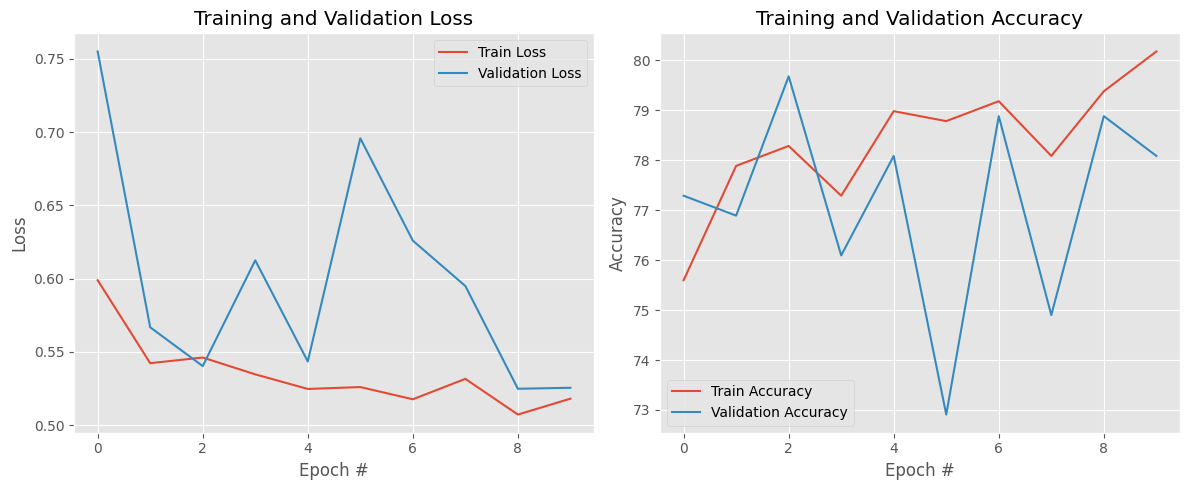

In [ ]:
# train model (check if model is ok)
set_random_seed()
model = CNN(dropout_rate)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'Device: {device}')
train_model(model, criterion, optimizer, num_epochs, train_loader, val_loader, device)


In [ ]:
def objective(trial):
    """
    Objective function for hyperparameter optimization with Optuna.
    """

    # seed for random numbers
    set_random_seed()

    # hyperparameters to optimize
    dropout_rate = trial.suggest_float("dropout_rate", 0.0, 0.5)
    learning_rate = trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True)

    # define dataloader
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # build model and move to device
    model = CNN(dropout_rate).to(device)

    # optimizer and loss function
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()

    # init list for output values
    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []

    # train model
    for epoch in range(num_epochs):
        train_loss, train_acc, _ = train_epoch(model, device, train_loader, criterion, optimizer)
        val_loss, val_acc = eval_epoch(model, device, val_loader, criterion)

        # save output from training and validation
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        val_losses.append(val_loss)
        val_accs.append(val_acc)

    # save output to a file
    output_metrics_file = os.path.join(WORKING_PATH,"CNN",f"metrics_{trial.number}.pkl")
    with open(output_metrics_file, "wb") as f:
        pickle.dump({"train_losses": train_losses,
                     "train_accs": train_accs,
                    "val_losses": val_losses,
                    "val_accs": val_accs}, f)

    # save path for output as user parameter
    trial.set_user_attr("metrics_path", output_metrics_file)

    return val_accs[-1]

In [ ]:
# build optuna study
# remove study if exists
try:
    optuna.delete_study(study_name="cnn_optimization", storage=os.path.join("sqlite:///","CNN","cnn_study.sqlite3"))
except:
    pass

study = optuna.create_study(study_name="cnn_optimization", direction="maximize",
                            storage=os.path.join("sqlite:///","CNN","cnn_study.sqlite3"),
                            sampler=optuna.samplers.TPESampler(seed=42))

# optimize
n_trials = 16

[I 2025-06-06 09:59:57,926] A new study created in RDB with name: cnn_optimization


In [ ]:
study.optimize(objective, n_trials=n_trials)

[I 2025-06-06 10:04:38,893] Trial 0 finished with value: 79.28286852589642 and parameters: {'dropout_rate': 0.18727005942368125, 'learning_rate': 0.07969454818643935}. Best is trial 0 with value: 79.28286852589642.
[I 2025-06-06 10:09:03,188] Trial 1 finished with value: 74.9003984063745 and parameters: {'dropout_rate': 0.36599697090570255, 'learning_rate': 0.015751320499779727}. Best is trial 0 with value: 79.28286852589642.
[I 2025-06-06 10:13:59,869] Trial 2 finished with value: 78.08764940239044 and parameters: {'dropout_rate': 0.07800932022121826, 'learning_rate': 0.002051110418843397}. Best is trial 0 with value: 79.28286852589642.
[I 2025-06-06 10:18:23,691] Trial 3 finished with value: 74.9003984063745 and parameters: {'dropout_rate': 0.02904180608409973, 'learning_rate': 0.05399484409787434}. Best is trial 0 with value: 79.28286852589642.
[I 2025-06-06 10:22:36,350] Trial 4 finished with value: 75.69721115537848 and parameters: {'dropout_rate': 0.3005575058716044, 'learning_ra

In [ ]:
# print best results
print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

# how relevant are the parameters?
optuna.visualization.plot_param_importances(study)

Best trial:
  Value:  79.6812749003984
  Params: 
    dropout_rate: 0.09091248360355031
    learning_rate: 0.002327067708383781


Device: cpu
Epoch 1, Loss: 0.6600064374506474, Acc: 71.71314741035856, Val Loss: 0.8271319344639778, Val Acc: 77.29083665338645, LR: 0.002327067708383781
Epoch 2, Loss: 0.5348789058625698, Acc: 78.38645418326693, Val Loss: 0.5521492399275303, Val Acc: 79.28286852589642, LR: 0.002327067708383781
Epoch 3, Loss: 0.5061533618718386, Acc: 79.28286852589642, Val Loss: 0.5746444202959538, Val Acc: 77.29083665338645, LR: 0.002327067708383781
Epoch 4, Loss: 0.5006691133603454, Acc: 81.07569721115537, Val Loss: 0.5519452169537544, Val Acc: 78.48605577689243, LR: 0.002327067708383781
Epoch 5, Loss: 0.4895858084782958, Acc: 81.17529880478088, Val Loss: 0.5331621468067169, Val Acc: 77.68924302788845, LR: 0.002327067708383781
Epoch 6, Loss: 0.48240820644423366, Acc: 81.47410358565737, Val Loss: 0.538063108921051, Val Acc: 81.67330677290836, LR: 0.002327067708383781
Epoch 7, Loss: 0.4774026907980442, Acc: 80.67729083665338, Val Loss: 0.5325303561985493, Val Acc: 80.4780876494024, LR: 0.00232706770838

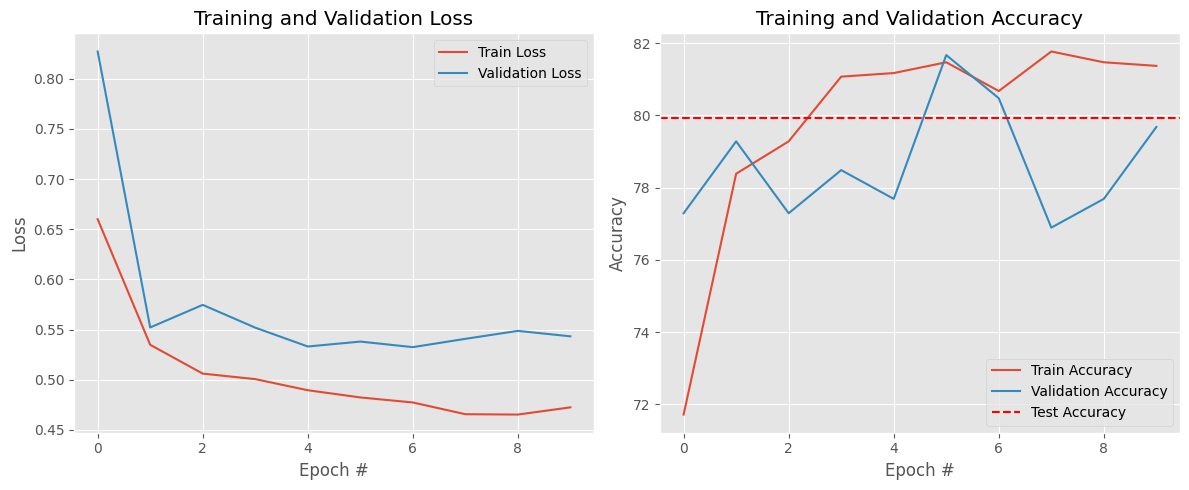

In [ ]:
# train final model
set_random_seed()
dropout_rate = study.best_params.get('dropout_rate')
learning_rate = study.best_params.get('learning_rate')
model = CNN(dropout_rate)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'Device: {device}')
train_model(model, criterion, optimizer, num_epochs, train_loader, val_loader,
            device, testloader = test_loader)


In [ ]:
# save model
torch.save(model, os.path.join(WORKING_PATH,'CNN','cnn_model.pth'))